In [ ]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ROOT = Path('/Users/apple/Library/CloudStorage/OneDrive-McGillUniversity/m2b3_Group - Claire/large_eye_tracking')
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from constants import *

# Configuration
TASK = 'freeviewing'
OUTPUT_DIR = RESULT_DIR / 'pca' / 'freeviewing_v2'
TOP_N_LOADINGS = 10


In [2]:
plt.style.use('default')

In [3]:
# Load fixations
path = INTERM_DATA_DIR / TASK / 'compiled_fixations.csv'
assert path.exists(), f'Missing file: {path}'
fix = pd.read_csv(path)
need = ['ID', 'onset', 'offset', 'duration', 'avg_x', 'avg_y']
miss = [c for c in need if c not in fix.columns]
assert not miss, f'Missing columns: {miss}'
fix['ID'] = fix['ID'].astype(str)
fix = fix[need].copy()
fix.head()


,ID,onset,offset,duration,avg_x,avg_y
0,20240719113615479,0.084,0.367,0.283,798.0,410.0
1,20240719113615479,0.383,0.600,0.217,424.0,495.0
2,20240719113615479,0.634,1.067,0.433,318.5,264.0
3,20240719113615479,1.101,1.301,0.200,925.0,278.0
4,20240719113615479,1.356,1.652,0.296,1485.5,318.5


In [4]:
# Build features (DataFrame per metric to avoid type issues)
g = fix.groupby('ID', sort=False)

fix_count = g.size().to_frame('fix_count').astype(float)
fix_dur_mean = g['duration'].mean().to_frame('fix_dur_mean')
fix_dur_cv = (g['duration'].std(ddof=0) / g['duration'].mean()).fillna(0.0).to_frame('fix_dur_cv')


disp_x = g['avg_x'].std(ddof=0).fillna(0.0).to_frame('fix_dispersion_x')
disp_y = g['avg_y'].std(ddof=0).fillna(0.0).to_frame('fix_dispersion_y')
# spatial_range = np.sqrt(disp_x['fix_dispersion_x']**2 + disp_y['fix_dispersion_y']**2).to_frame('fix_spatial_range')

# onset_min = g['onset'].min()
# offset_max = g['offset'].max()
# temporal_range = (offset_max - onset_min).to_frame('fix_temporal_range')


feat = (fix_count
        .join([fix_dur_mean, fix_dur_cv, disp_x, disp_y,])
        .reset_index().rename(columns={'ID': 'ID'}))

feat['ID'] = feat['ID'].astype(str)
# feat['fix_rate'] = feat['fix_count'] / 10.0

for c in feat.columns:
    if c == 'ID':
        continue
    feat[c] = pd.to_numeric(feat[c], errors='coerce')
feat = feat.fillna(feat.median(numeric_only=True))


In [5]:

'''def _px_to_dva_local(px):
    px_arr = np.asarray(px, dtype=float)
    return 2.0 * np.degrees(np.arctan((px_arr * PX_PER_CM) / (2.0 * SCREENDIST)))'''

'def _px_to_dva_local(px):\n    px_arr = np.asarray(px, dtype=float)\n    return 2.0 * np.degrees(np.arctan((px_arr * PX_PER_CM) / (2.0 * SCREENDIST)))'

In [6]:

sacc_speed_mean = {}
sacc_distance_mean = {}

for pid, dfid in fix.groupby('ID', sort=False):
    dfid = dfid.sort_values('onset')
    if len(dfid) < 2:
        sacc_speed_mean[pid] = np.nan
        sacc_distance_mean[pid] = np.nan
        continue

    x = dfid['avg_x'].to_numpy()
    y = dfid['avg_y'].to_numpy()
    onsets = dfid['onset'].to_numpy()
    offsets = dfid['offset'].to_numpy()

    dx = np.diff(x)
    dy = np.diff(y)
    amps = np.hypot(dx, dy)
    durs = onsets[1:] - offsets[:-1]            # saccade duration (s), gap between fixations

    valid = durs > 1e-3
    if np.any(valid):
        speeds = amps[valid] / durs[valid]  # °/s
        sacc_speed_mean[pid] = float(np.nanmean(speeds)) if speeds.size else np.nan
    else:
        sacc_speed_mean[pid] = np.nan

    sacc_distance_mean[pid] = float(np.nanmean(amps)) if amps.size else np.nan

_sacc = pd.DataFrame({
    'ID': list(sacc_speed_mean.keys()),
    'saccade_speed_mean': [sacc_speed_mean[k] for k in sacc_speed_mean.keys()],
    'saccade_distance_mean': [sacc_distance_mean[k] for k in sacc_speed_mean.keys()],
})
_sacc['ID'] = _sacc['ID'].astype(str)
feat = feat.merge(_sacc, on='ID', how='left')


# Pupil metrics
pupil_mean = []
pupil_cv = []

for pid in feat['ID']:
    p_mean = np.nan
    p_cv = np.nan
    try:
        pfile = PROC_DATA_DIR / TASK / f"{pid}.csv"
        dfp = pd.read_csv(pfile)

        cols = [c for c in ['label', 'pupil_size', 'time_from_start'] if c in dfp.columns]
        if len(cols) == 3:
            dfp = dfp[cols]
            dfp = dfp[(dfp['label'] == 'p') & (dfp['time_from_start'] <= 10)]
            if len(dfp) > 0:
                v = pd.to_numeric(dfp['pupil_size'], errors='coerce').to_numpy()
                v = v[~np.isnan(v)]
                if v.size:
                    p_mean = float(np.nanmean(v))
                    sd = float(np.nanstd(v, ddof=0))
                    p_cv = float(sd / p_mean) if p_mean > 0 else np.nan
    except Exception:
        pass

    pupil_mean.append(p_mean)
    pupil_cv.append(p_cv)

_pupil = pd.DataFrame({'ID': feat['ID'].astype(str),
                       'pupil_mean': pupil_mean,
                       'pupil_cv': pupil_cv})
feat = feat.merge(_pupil, on='ID', how='left')


In [7]:
print(feat.columns.tolist(), len(feat.columns.tolist()))

['ID', 'fix_count', 'fix_dur_mean', 'fix_dur_cv', 'fix_dispersion_x', 'fix_dispersion_y', 'saccade_speed_mean', 'saccade_distance_mean', 'pupil_mean', 'pupil_cv'] 10


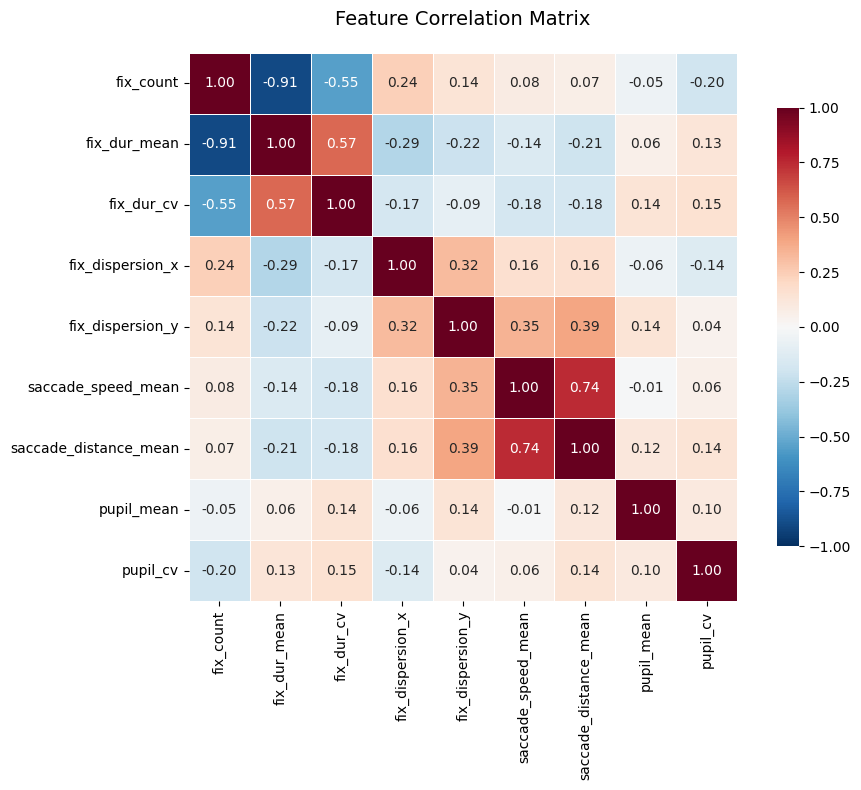

In [14]:
# Feature Correlation Heatmap
import seaborn as sns

corr_matrix = feat.drop(columns=['ID']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [ ]:
# PCA compute + save
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

ids = feat['ID'].astype(str)
X = feat.drop(columns=['ID']).apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median(numeric_only=True))

X_mat = X.to_numpy()
if 1:
    X_mat = StandardScaler().fit_transform(X_mat)

max_comp = int(min(X_mat.shape[0], X_mat.shape[1]))

pca = PCA(n_components=max_comp)
X_pca = pca.fit_transform(X_mat)

# Save csvs
scores = pd.DataFrame({'ID': ids})
for i in range(X_pca.shape[1]):
    scores[f'PC{i+1}'] = X_pca[:, i]
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])])
variance = pd.DataFrame({'PC': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
                         'var': pca.explained_variance_ratio_,
                         'cumvar': np.cumsum(pca.explained_variance_ratio_)})

scores.to_csv(OUTPUT_DIR / 'scores.csv', index=False)
loadings.to_csv(OUTPUT_DIR / 'loadings.csv')
variance.to_csv(OUTPUT_DIR / 'variance.csv', index=False)

# Feature importance (absolute loadings)
abs_load = loadings.abs()
abs_load.to_csv(OUTPUT_DIR / 'feature_importance.csv')

print('Features shape:', X.shape)
print('Scores shape:', scores.shape)
print('Variance head:\n', variance.head())
print('Saved to:', OUTPUT_DIR)


Features shape: (1233, 9)
Scores shape: (1233, 10)
Variance head:
     PC       var    cumvar
0  PC1  0.315024  0.315024
1  PC2  0.208280  0.523304
2  PC3  0.115876  0.639180
3  PC4  0.112783  0.751963
4  PC5  0.092085  0.844048
Saved to: /Users/apple/Library/CloudStorage/OneDrive-McGillUniversity/m2b3_Group - Claire/large_eye_tracking/analysis_results/pca/freeviewing_v2


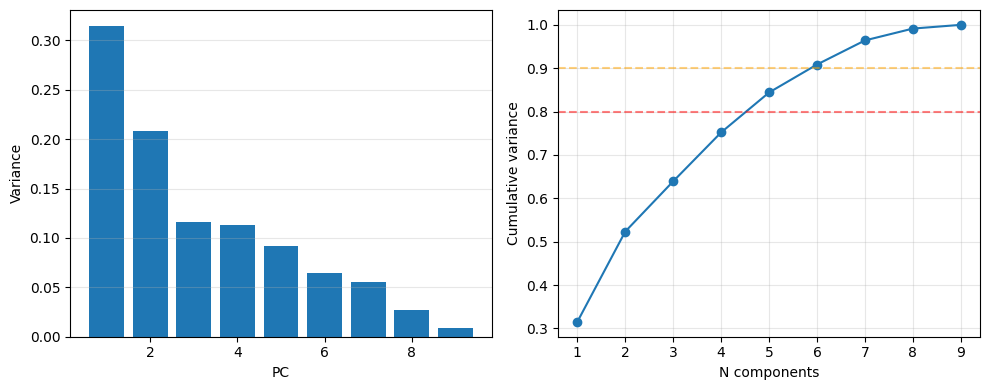

In [10]:
# Variance and cumulative plots
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(variance['var']) + 1), variance['var'])
plt.xlabel('PC')
plt.ylabel('Variance')
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(variance['cumvar']) + 1), variance['cumvar'], 'o-')
plt.axhline(0.8, color='r', linestyle='--', alpha=0.5)
plt.axhline(0.9, color='orange', linestyle='--', alpha=0.5)
plt.xlabel('N components')
plt.ylabel('Cumulative variance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


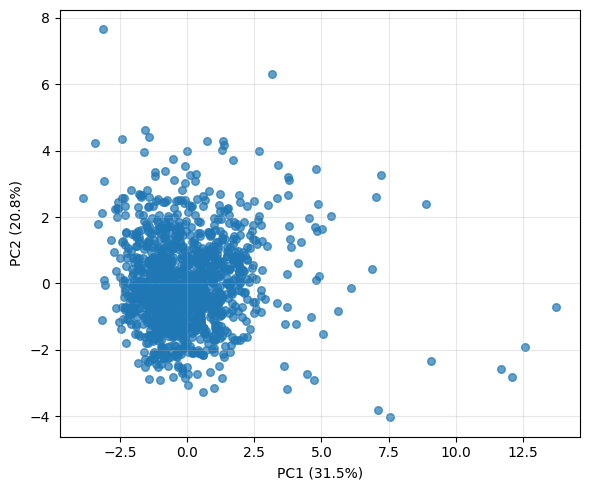

In [11]:
# PC1-PC2 scatter
if 'PC1' in scores.columns and 'PC2' in scores.columns:
    plt.figure(figsize=(6, 5))
    plt.scatter(scores['PC1'], scores['PC2'], s=30, alpha=0.7)
    if len(variance) >= 2:
        plt.xlabel(f"PC1 ({variance.loc[0, 'var']*100:.1f}%)")
        plt.ylabel(f"PC2 ({variance.loc[1, 'var']*100:.1f}%)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
print(feat.columns.tolist(), len(feat.columns.tolist()))

['ID', 'fix_count', 'fix_dur_mean', 'fix_dur_cv', 'fix_dispersion_x', 'fix_dispersion_y', 'saccade_speed_mean', 'saccade_distance_mean', 'pupil_mean', 'pupil_cv'] 10


In [12]:

# FEATURES WITH LOWEST CONTRIBUTION TO PCA
mean_loading = loadings.abs().mean(axis=1).sort_values()



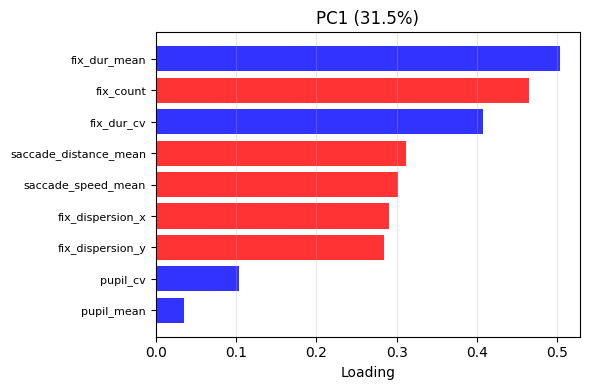

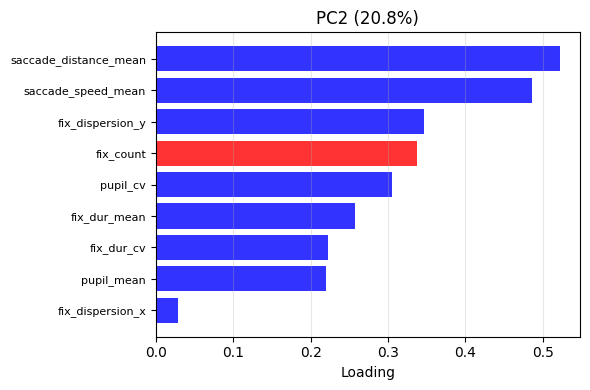

In [15]:
# Top loadings for first PCs
k = min(2, loadings.shape[1])
for i in range(k):
    pc = f'PC{i+1}'
    top = loadings[pc].abs().sort_values(ascending=False).head(9)
    colors = ['red' if loadings.loc[f, pc] < 0 else 'blue' for f in top.index]
    
    plt.figure(figsize=(6, 4))
    plt.barh(range(len(top)), top.values, color=colors, alpha=0.8)
    plt.yticks(range(len(top)), top.index, fontsize=8)
    plt.gca().invert_yaxis()
    plt.xlabel('Loading')
    if len(variance) > i:
        plt.title(f'{pc} ({variance.loc[i, "var"]*100:.1f}%)')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()


In [ ]:
print(feat.columns.tolist(), len(feat.columns.tolist()))

['ID', 'fix_count', 'fix_dur_mean', 'fix_dur_cv', 'fix_dispersion_x', 'fix_dispersion_y', 'saccade_speed_mean', 'saccade_distance_mean', 'pupil_mean', 'pupil_cv'] 10
